In [1]:
import xnet
import json
import glob
import util

import numpy as np
import matplotlib.pyplot as plt

from igraph import *
from util import save,load
from scipy.stats import pearsonr
from collections import defaultdict
from matplotlib.patches import Rectangle
from matplotlib.ticker import MaxNLocator
from matplotlib import transforms,gridspec

In [2]:
attr_pacs = util.get_attr_pacs() # nome dos atributos dos vértices que contem os códigos PACS
pac_list = util.get_pac_list() # lista de códigos válidos

In [4]:
data = xnet.xnet2igraph('data/citation_network_ge1985_pacs.xnet')

filenames = sorted(glob.glob('data/pacs/2lvls/*_delta4_multilevel2.xnet'))
pac_nets = []
for filename in filenames:
	net = xnet.xnet2igraph(filename)
	pac_nets.append(net)

In [3]:
def plot_average_div(authors_divs,valid_authors,filename,title):
    divs = defaultdict(lambda:[])
    for year,authors in valid_authors.items():
        for author in authors:
            if author in authors_divs:
                a_div = authors_divs[author]
                if year in a_div:
                    divs[year].append(a_div[year])
                else:
                    print(year,author)
                    
    X = []
    Y = []
    yerr = []
    for year,divs in divs.items():
        X.append(year)
        Y.append(np.mean(divs))
        yerr.append(np.std(divs))

    X = np.asarray(X)
    Y = np.asarray(Y)
    yerr = np.asarray(yerr)

    idxs = np.argsort(X)
    X = X[idxs]
    Y = Y[idxs]
    yerr = yerr[idxs]
    
    print(X)
    print(Y)
    print(yerr)

    plt.figure(figsize=(10,3))
    plt.errorbar(X,Y,yerr=yerr,marker='o',ls='-')
    plt.xticks(rotation=45)
    plt.xlabel('year')
    plt.ylabel('diversity')
    plt.title(title)
    plt.tight_layout()
    plt.savefig(filename)
    plt.close()

In [6]:
history_out = load(history_out_filename)
history_in = load(history_in_filename)
authors_in_div = load('data2\\authors_in_div.json') # diversidade das publicações que citam o autor (author in)
authors_out_div = load('data2\\authors_out_div.json') # diversidade das publicações citadas (author out)
authors_in_sim = load('data2\\authors_in_sym.json'))
authors_out_sim = load('data2\\authors_out_sym.json')

In [11]:
valid_authors_by_area = util.get_area(data,pac_nets,util.get_pacs_paper_published,4)

current year 1986
current year 1987
current year 1988
current year 1989
current year 1990
current year 1991
current year 1992
current year 1993
current year 1994
current year 1995
current year 1996
current year 1997
current year 1998
current year 1999
current year 2000
current year 2001
current year 2002
current year 2003
current year 2004
current year 2005
current year 2006


comentário 26/06/2020:
a partir desse ponto estava sendo utilizado os autores com min 25 citações e referências
precisa ser adaptado para a nova versão que seleciona os autores utilizando também rastreamento

In [13]:
# top1000_in = load('authors_in_ranking1000_by_year.json')
# top1000_out = load('authors_out_ranking1000_by_year.json')
top500_in = load('data/authors_in_ranking500_by_year.json')
top500_out = load('data/authors_out_ranking500_by_year.json')

top_min25 = load('data/authors_ranking_min25_by_year.json')
for year,authors in top_min25.items():
    print(year,len(authors))

# plot_average_div(authors_in_div,top_min25,'temp/2lvls_2multilevel/min25_in_average_div_in.pdf','média de diversidade das citações dos autores com min 25 citações e 25 referências')
# plot_average_div(authors_out_div,top_min25,'temp/2lvls_2multilevel/min25_in_average_div_out.pdf','média de diversidade das referências dos autores com min 25 citações e 25 referências')

1990 198
1991 776
1992 1656
1993 2894
1994 3196
1995 3637
1996 4161
1997 4389
1998 4893
1999 5310
2000 5466
2001 5629
2002 6884
2003 7349
2004 8998
2005 10624
2006 11263
2007 11656
2008 12620
2009 12889
2010 13252


In [13]:
# top 10 average div
# plot_average_div(authors_in_div,top1000_in,'temp/2lvls_2multilevel/top1000_in_average_div_in.pdf','média de diversidade das citações do top 1000 autores com mais citações')
# plot_average_div(authors_out_div,top1000_in,'temp/2lvls_2multilevel/top1000_in_average_div_out.pdf','média de diversidade das referências do top 1000 autores com mais citações')
# plot_average_div(authors_out_div,top1000_out,'temp/2lvls_2multilevel/top1000_out_average_div_out.pdf','média de diversidade das referências do top 1000 autores com mais referências')
# plot_average_div(authors_in_div,top1000_out,'temp/2lvls_2multilevel/top1000_out_average_div_in.pdf','média de diversidade das citações do top 1000 autores com mais referências')

In [14]:
# top 10 average div
# plot_average_div(authors_in_div,top500_in,'temp/2lvls_2multilevel/top500_in_average_div_in.pdf','média de diversidade das citações do top 500 autores com mais citações')
# plot_average_div(authors_out_div,top500_in,'temp/2lvls_2multilevel/top500_in_average_div_out.pdf','média de diversidade das referências do top 500 autores com mais citações')
# plot_average_div(authors_out_div,top500_out,'temp/2lvls_2multilevel/top500_out_average_div_out.pdf','média de diversidade das referências do top 500 autores com mais referências')
# plot_average_div(authors_in_div,top500_out,'temp/2lvls_2multilevel/top500_out_average_div_in.pdf','média de diversidade das citações do top 500 autores com mais referências')

In [14]:
def get_y(xs,X1,Y1):
    ys1 = []
    for x in xs:
        x = str(x)
        try:
            i = X1.index(x)
            v = Y1[i]
        except:
            v = 0
        ys1.append(v)
    return ys1

In [15]:
def get_div_points(valid,authors1,authors2,valid_authors_by_area):
    div_points = defaultdict(lambda:defaultdict(lambda:[]))
    
    for year,valid_authors in valid_authors_by_area.items():
        year = str(year)
        for comm,authors in valid_authors.items():
            authors = set(authors)
            for author in authors:
                if author in valid[year] and author in authors1 and author in authors2:
                    x = authors1[author]
                    y = authors2[author]
                    if year in x and year in y:
                        div_points[year][comm].append((x[year],y[year]))
    return div_points

def plot_line_with_freq(fig,gs,X,Y,title,xlabel,ylabel,comm):
    '''
    fig = plt.figure(figsize=(16, 8)) 
    fig.suptitle(year)
    gs = gridspec.GridSpec(2, 4, width_ratios=[1,3,1,3],height_ratios=[3,1]) 
    '''
    
    #----------------------------------------------------------------------
    # todos os dados
#     print(comm)
    ax1 = fig.add_subplot(gs[:3,comm*4+1:comm*4+4])
    ax1.scatter(X, Y, lw=2, alpha=0.4)
    ax1.label_outer()
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)
    ax1.set_title(title)
#     ax1.legend()
    
#     rect = Rectangle((min(X0),min(Y0)),max(X0)-min(X0),max(Y0)-min(Y0),fill=False,color='red')
#     ax1.add_patch(rect)
    
    ax2 = fig.add_subplot(gs[:3,comm*4],sharey=ax1)
    ax2.set_ylabel(ylabel)
    ax2.label_outer()
    n, bins, patches = ax2.hist(Y,50,orientation='horizontal')
    ax2.invert_xaxis()

    ax3 = fig.add_subplot(gs[3,comm*4+1:comm*4+4],sharex=ax1)
    ax3.set_xlabel(xlabel)
    ax3.label_outer()
    n, bins, patches = ax3.hist(X, 50)
    ax3.invert_yaxis()
    
    #----------------------------------------------------------------------
    # retângulo
    '''    
    ax1 = fig.add_subplot(gs[3])
    ax1.scatter(X0, Y0, lw=2, alpha=0.4)
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)
    ax1.set_title(title0)
    ax1.legend()
    
    ax2 = fig.add_subplot(gs[2],sharey=ax1)
#     ax2.set_ylabel(ylabel)
    n, bins, patches = ax2.hist(Y0, 50,orientation='horizontal')
    ax2.invert_xaxis()

    ax3 = fig.add_subplot(gs[7],sharex=ax1)
    ax3.set_xlabel(xlabel)
    n, bins, patches = ax3.hist(X0, 50)
    ax3.invert_yaxis()
    '''
    #----------------------------------------------------------------------
    
#     fig.savefig(filename)
#     plt.close()
    return fig

def axis_filter(X):
    X_count,X_bins = np.histogram(X, bins=50)
    
    idx_max = np.argmax(X_count)
    
    q25 = X_bins[max(idx_max-3,0)]
    q75 = X_bins[min(idx_max+4,len(X_bins)-1)]
    X_idxs = np.logical_and(X >= q25, X < q75)
    return X_idxs
    
def filter_subseq(X,Y):
    X_idxs = axis_filter(X)
    Y_idxs = axis_filter(Y)
#     q25 = np.quantile(Y,0.25)
#     q75 = np.quantile(Y,0.75)
#     Y_idxs = np.logical_and(Y > q25, Y < q75)
    
    idxs = np.logical_and(X_idxs,Y_idxs)
    if sum(idxs) < 3:
        idxs = X_idxs
    return X[idxs],Y[idxs]
    
def plot_div_points(div_points,xlabel,ylabel,name,header):
    corrs = []
    corrs0 = []
    years = []
    for year in ['2006','2007','2008','2009','2010']:
        print('year',year)
        points_by_comm = div_points[year]
        print(points_by_comm)
        if len(points_by_comm) == 0:
            continue
        
        N = max([int(x) for x in points_by_comm])
        print('N',N,points_by_comm.keys())
        
        fig = plt.figure(figsize=(4*N,4))
        fig.suptitle(year)
        gs = gridspec.GridSpec(4,4*N,figure=fig)
        
        
        for comm,points in points_by_comm.items():
            #TODO AQUI
            points = np.asarray(points)
            X = points[:,0]
            Y = points[:,1]
            if len(X) <= 2:
                continue
#             X0,Y0 = filter_subseq(X,Y)
            pear = pearsonr(X,Y)[0]
#             pear0 = pearsonr(X0,Y0)[0]
#             title0 = "comm=%s; zoom \n(pear=%.3f; No points=%d)" % (comm,pear0,len(X0))

            years.append(year)
            corrs.append(pear)
            print(year,pear)
#             corrs0.append(pear0)

            title = "comm=%s; original \n(pear=%.3f; No points=%d)" % (comm,pear,len(X))

            #plt.locator_params(axis='x',integer=MaxNLocator(integer=True))
            #plt.xlabel(xlabel)
            #plt.ylabel(ylabel)
            #plt.xticks(rotation=45)
#             filename = header+'div_points_%s_%s_%s_%s_%s_zoom.pdf'%(name,year,xlabel,ylabel,comm)

            fig = plot_line_with_freq(fig,gs,X,Y,title,xlabel,ylabel,int(comm)-1)
        plt.tight_layout() 
        fig.savefig('sim_points_%s.pdf'%year)
    plt.grid(True,alpha=0.3)
    plt.plot(years,corrs,'o',ls='-',color='blue',label='original')
#     plt.plot(years,corrs0,'o',ls='-',color='green',label='zoom')
    plt.title('correlação (pearson entre \n %s e %s)' % (xlabel,ylabel))
    #plt.xlabel(xlabel)
    #plt.ylabel(ylabel)
    #plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.locator_params(axis='x',integer=MaxNLocator(integer=True))
    plt.savefig(header+'sim_correlacao_%s_%s_%s.pdf' % (name,xlabel,ylabel))
    plt.close()

In [16]:
import seaborn as sns
import pandas as pd

In [27]:
def plot_div_points_seaborn(div_points,xlabel,ylabel,name,header):
    corrs = []
    corrs_zoom = []
    years = []
    for year in ['1998','1999','2000','2001','2002','2003','2004','2005','2006','2007','2008','2009','2010']:
        print('year',year)
        points_by_comm = div_points[year]
        if len(points_by_comm) == 0:
            continue
        all_points = []
        for comm,points in points_by_comm.items():
            all_points += points
        all_points = np.asarray(all_points)
        X = all_points[:,0]
        Y = all_points[:,1]
        if len(X) <= 2:
            continue
        X_zoom,Y_zoom = filter_subseq(X,Y)
        
        percente_in_zoom = 100*len(X_zoom)/len(X)
        
        pear = pearsonr(X,Y)[0]
        
        header = 'original'
        title = "%s \n(pear=%.3f; N of points=%d)" % (header,pear,len(X))
        df = pd.DataFrame({xlabel:X,ylabel:Y})
        g = sns.jointplot(x=xlabel, y=ylabel,data=df,kind="kde",cmap='Blues')
#         g.ax_joint.axvline(min(X_zoom),color='r')
#         g.ax_joint.axvline(max(X_zoom),color='r')
#         g.ax_joint.axhline(min(Y_zoom),color='r')
#         g.ax_joint.axhline(max(Y_zoom),color='r')
        plt.suptitle(title)
        plt.savefig('temp/joint_plot/joint_plot_%s_%s_%s_%s.pdf' % (xlabel,ylabel,year,header))
        
        corrs.append(pear)
        years.append(year)
        
        pear = pearsonr(X_zoom,Y_zoom)[0]
        corrs_zoom.append(pear)
        header = 'zoom'
        title = "%s \n(pear=%.3f; N of points=%d; %.3f%%)" % (header,pear,len(X),percente_in_zoom)
        df = pd.DataFrame({xlabel:X_zoom,ylabel:Y_zoom})
        sns.jointplot(x=xlabel, y=ylabel,data=df,kind="kde",color='b')
        plt.suptitle(title)
        plt.savefig('temp/joint_plot/joint_plot_%s_%s_%s_%s.pdf' % (xlabel,ylabel,year,header))

    plt.figure(figsize=(4,3))
    plt.plot(years,corrs,'o',ls='-',color='blue',label='original')
    plt.plot(years,corrs_zoom,'o',ls='-',color='green',label='zoom')
    plt.title('correlação (pearson entre \n %s e %s)' % (xlabel,ylabel))
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.locator_params(axis='x',integer=MaxNLocator(integer=True))
    plt.savefig('temp/joint_plot/sim_correlacao_%s_%s_%s.pdf' % (name,xlabel,ylabel))
    plt.close()

In [18]:
header = 'temp/2lvls_2multilevel/'

In [19]:
# header = 'temp/3lvls_2multilevel/'
div_points = get_div_points(top_min25,authors_in_sim,authors_out_sim,valid_authors_by_area) 

year 1998
year 1999
year 2000
year 2001
year 2002
year 2003
year 2004
year 2005
year 2006
year 2007
year 2008


/home/carol/.local/lib/python3.6/site-packages/seaborn/axisgrid.py:1675: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(height, height))
/home/carol/.local/lib/python3.6/site-packages/seaborn/axisgrid.py:1675: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(height, height))


year 2009


/home/carol/.local/lib/python3.6/site-packages/seaborn/axisgrid.py:1675: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(height, height))
/home/carol/.local/lib/python3.6/site-packages/seaborn/axisgrid.py:1675: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(height, height))


year 2010


/home/carol/.local/lib/python3.6/site-packages/seaborn/axisgrid.py:1675: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(height, height))
/home/carol/.local/lib/python3.6/site-packages/seaborn/axisgrid.py:1675: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(height, height))
/home/carol/.local/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitl

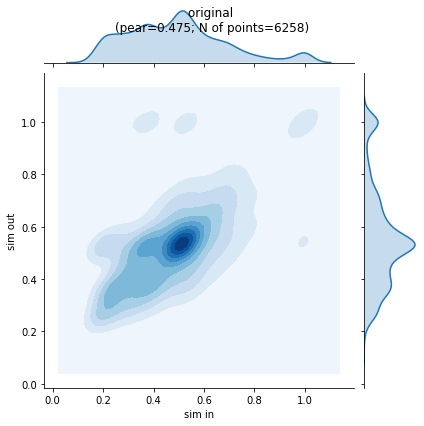

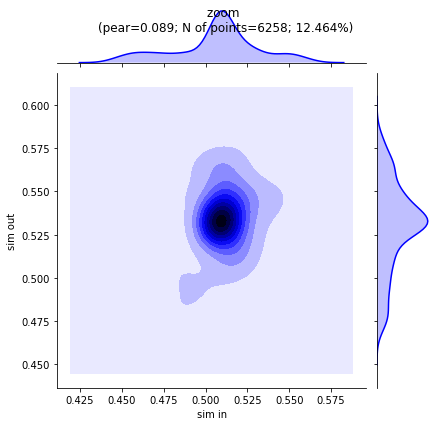

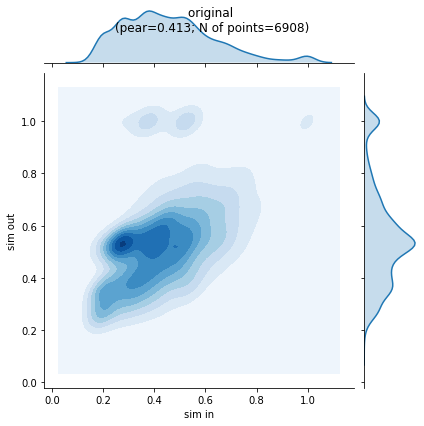

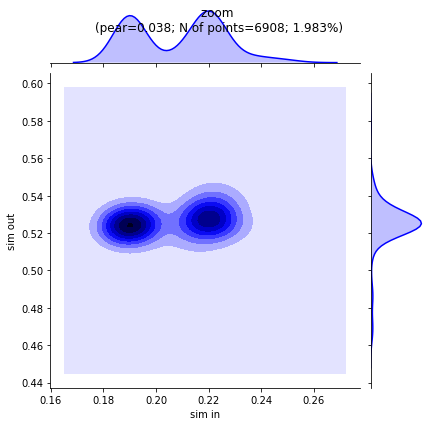

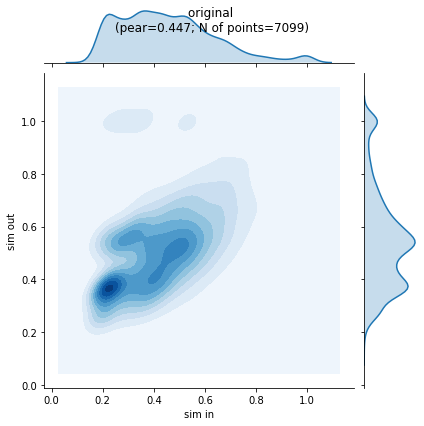

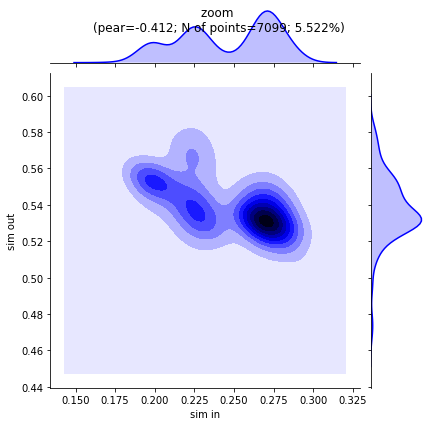

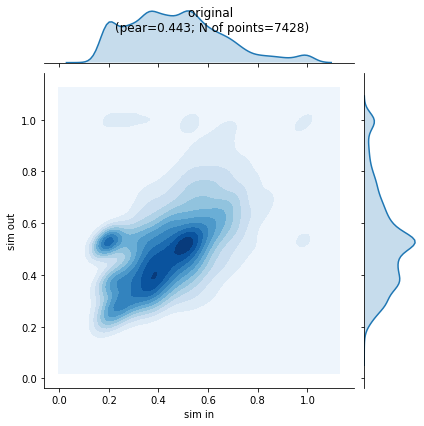

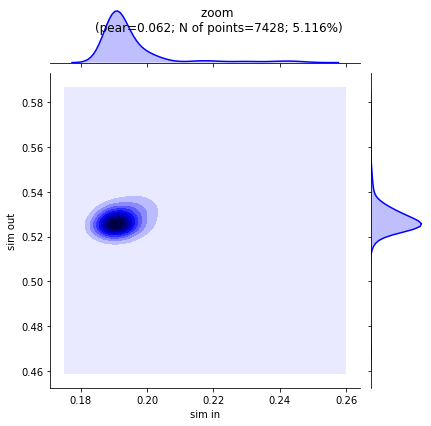

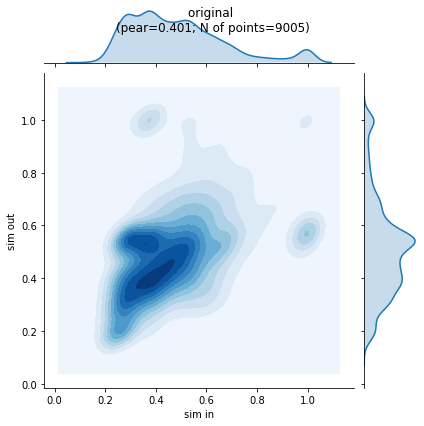

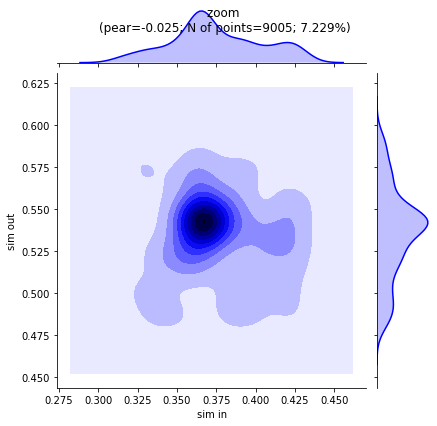

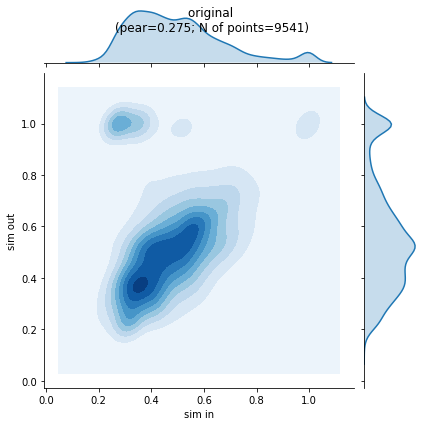

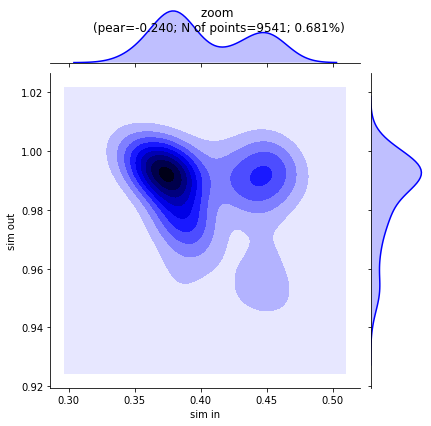

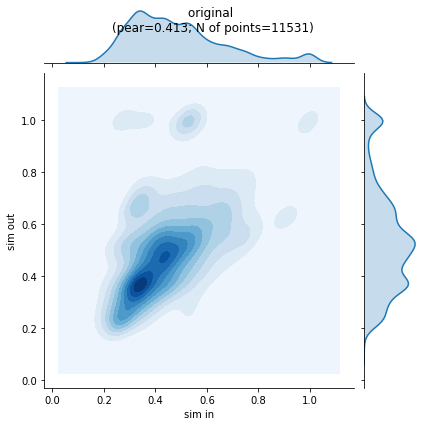

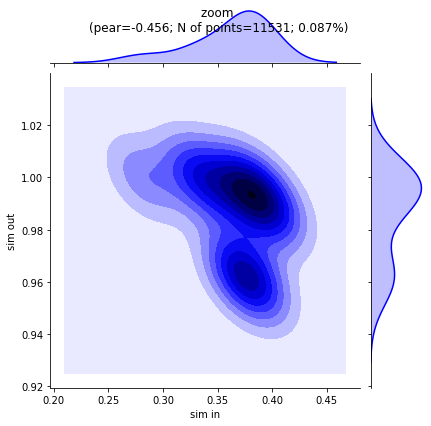

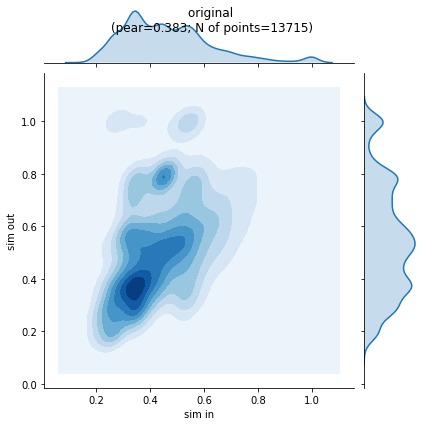

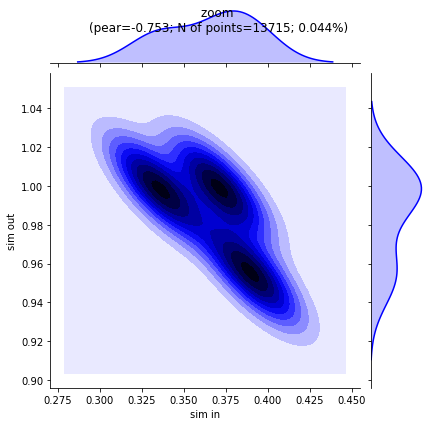

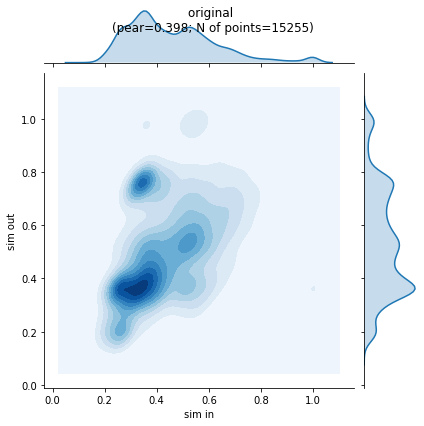

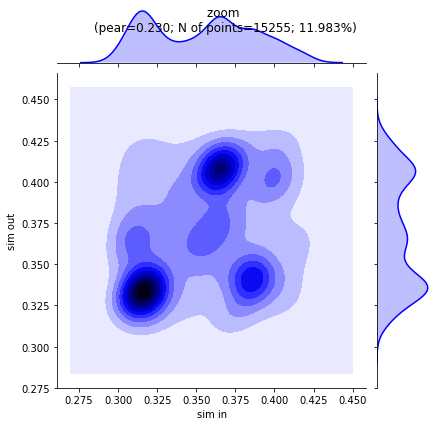

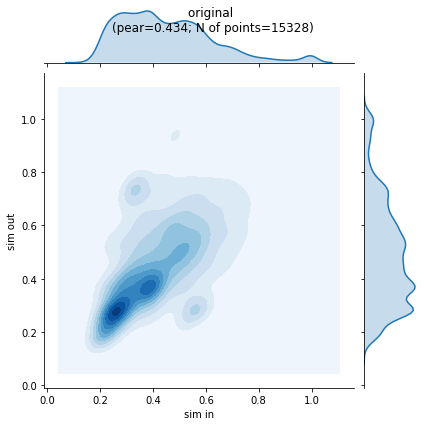

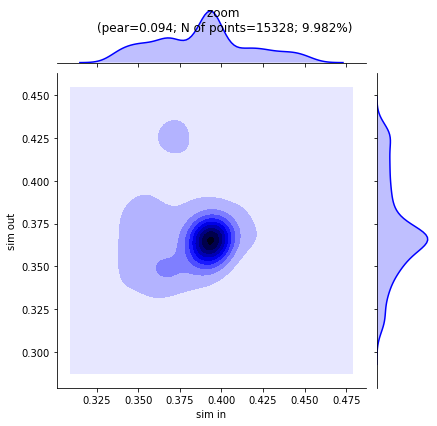

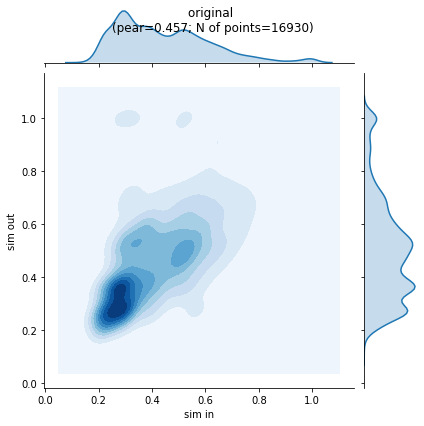

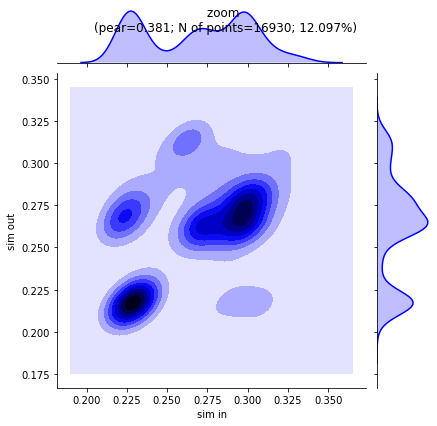

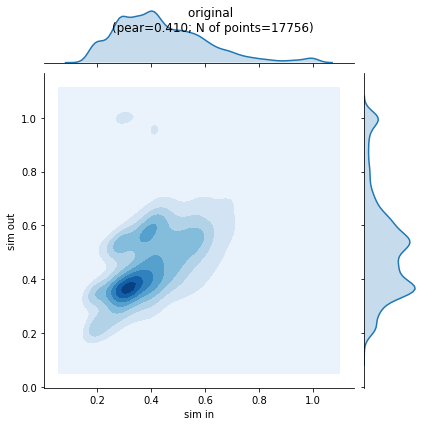

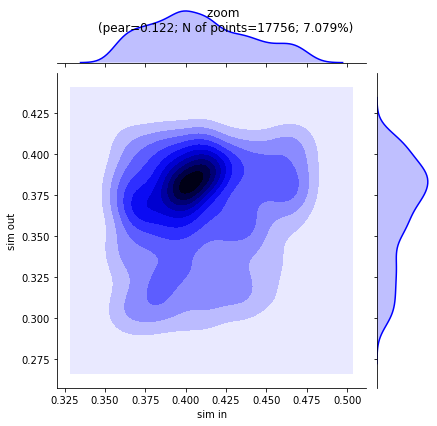

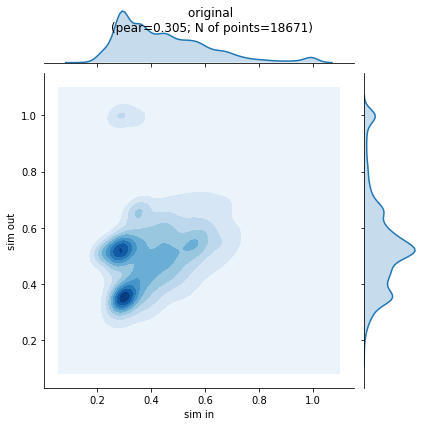

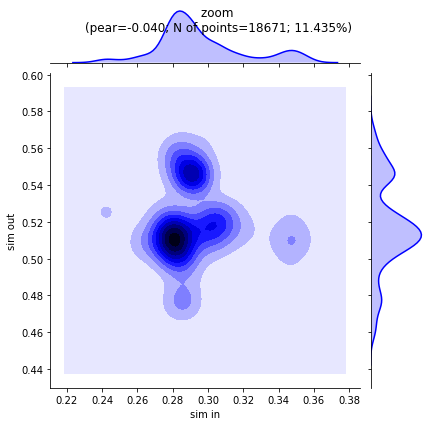

In [28]:
plot_div_points_seaborn(div_points,'sim in','sim out','min 25 citações e referências',header)

# div_points = get_div_points(top500_in,authors_in_div,authors_out_div)
# plot_div_points(div_points,'div in','div out','top 500')

In [22]:
freq_in = load('data/authors_in_freq2.json')
freq_out = load('data/authors_out_freq2.json')

year 2006
defaultdict(<function get_div_points.<locals>.<lambda>.<locals>.<lambda> at 0x7f6cad395d08>, {'5': [(0.35885324167116955, 7), (0.5421267173041117, 4), (0.42893304891200695, 10), (0.8519307119635668, 9), (0.49928573099300394, 1), (0.5438371769300666, 17), (0.5161962314027496, 2), (0.7562726035995578, 50), (0.4433308408685188, 2), (0.271469171731962, 42), (0.2941228336549476, 2), (0.6350760777604229, 1), (0.581388910062678, 5), (0.5379675420491027, 0), (0.43508962742133606, 4), (0.37259440201073407, 27), (0.3971509215858907, 87), (0.4753211141768043, 29), (0.3850789182109242, 8), (0.2755360542244977, 11), (0.45742247245901685, 2), (0.6160326132038126, 14), (0.4096527872721771, 1), (0.5368734588722628, 0), (0.46802138995595904, 25), (0.456196892139362, 2), (0.6823280188180262, 8), (0.4353739954988817, 13), (0.4716175767861684, 26), (0.6699703611646836, 0), (0.43429082663572205, 17), (0.6299905121298187, 9), (0.2840202846602058, 9), (0.7260323475575662, 11), (0.37592279994271377,

2006 -0.0416685328368223
2006 -0.1530780951720229
2006 -0.21375820351324604
2006 -0.13079301229347431
2006 -0.5200457248356705
2006 -0.16099204808477624
2006 -0.3651266390612884
year 2007
defaultdict(<function get_div_points.<locals>.<lambda>.<locals>.<lambda> at 0x7f6cad395e18>, {'5': [(0.6421807708205092, 1), (0.28594790496591166, 6), (1.0, 2), (0.7338166541049498, 5), (0.7321237323047728, 20), (0.49590703690808086, 11), (0.5689194258240374, 4), (0.47198156805004204, 5), (0.4678037064422799, 2), (0.5060939546003861, 2), (0.5786986104736483, 30), (0.29424028566714017, 30), (0.4094251516676218, 7), (0.6530352463169982, 0), (0.5574066667478588, 5), (0.43315460711119935, 0), (0.3712334928930685, 3), (0.435800597000214, 4), (0.7216448278673457, 3), (0.47599275773830835, 8), (0.48768762847425, 5), (0.3510512690114216, 4), (0.4873763053998645, 10), (0.5696148191496623, 12), (0.4794085755046565, 76), (0.391929500481637, 8), (0.46689454770620353, 22), (0.4481693726718549, 5), (0.7045720822543

2007 -0.19245600808763846
2007 -0.10520123795488791
2007 -0.14388884778415068
2007 -0.12294682547159907
2007 -0.43143981516027635
2007 -0.5215378761853975
2007 -0.3493900240734067
year 2008
defaultdict(<function get_div_points.<locals>.<lambda>.<locals>.<lambda> at 0x7f6cad395c80>, {'6': [(0.6330585185806165, 3), (0.287091529258693, 17), (1.0, 1), (0.4094251516676218, 22), (0.41697407218809207, 0), (0.5668559991252956, 12), (0.5304619871885687, 30), (0.4253707124458874, 14), (0.4965195632651966, 7), (0.42207746673960456, 0), (0.4264978309231652, 3), (0.6119457685221895, 23), (0.580729995589928, 33), (0.3507038563095749, 17), (0.2415131126314539, 13), (0.38308370146568493, 6), (0.5483008626681442, 3), (0.6446258790570909, 21), (0.4644680104524642, 1), (0.3507870525347375, 5), (0.3775191556290426, 4), (0.4134995611444893, 4), (0.6561872720926625, 18), (0.5532880728832436, 11), (1.0, 19), (0.2835849461828198, 2), (0.692072744230843, 1), (0.4942457627943002, 4), (0.4443807073511575, 61), (

2008 -0.13467443693724068
2008 -0.19558028662123833
2008 -0.13153562610671252
2008 -0.15280497846433186
2008 -0.35275438400721126
2008 -0.506010071175442
2008 -0.1221836793507887
year 2009
defaultdict(<function get_div_points.<locals>.<lambda>.<locals>.<lambda> at 0x7f6cba004ae8>, {})
year 2010
defaultdict(<function get_div_points.<locals>.<lambda>.<locals>.<lambda> at 0x7f6cba004e18>, {})


/home/carol/.local/lib/python3.6/site-packages/ipykernel_launcher.py:153: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.category.StrCategoryLocator'>


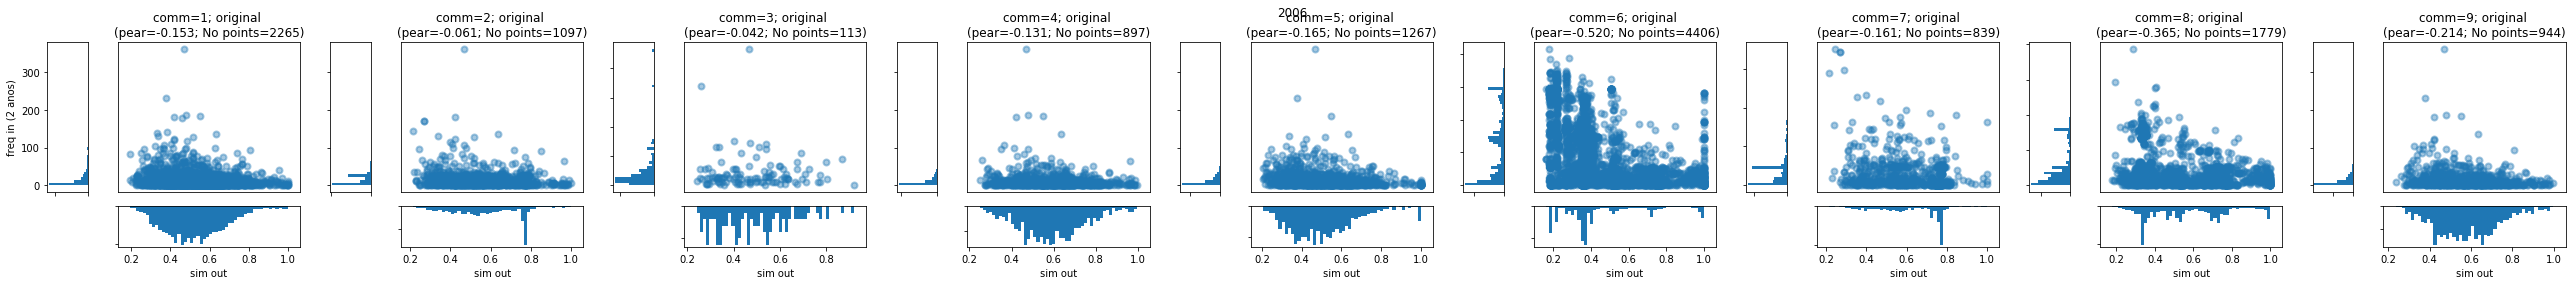

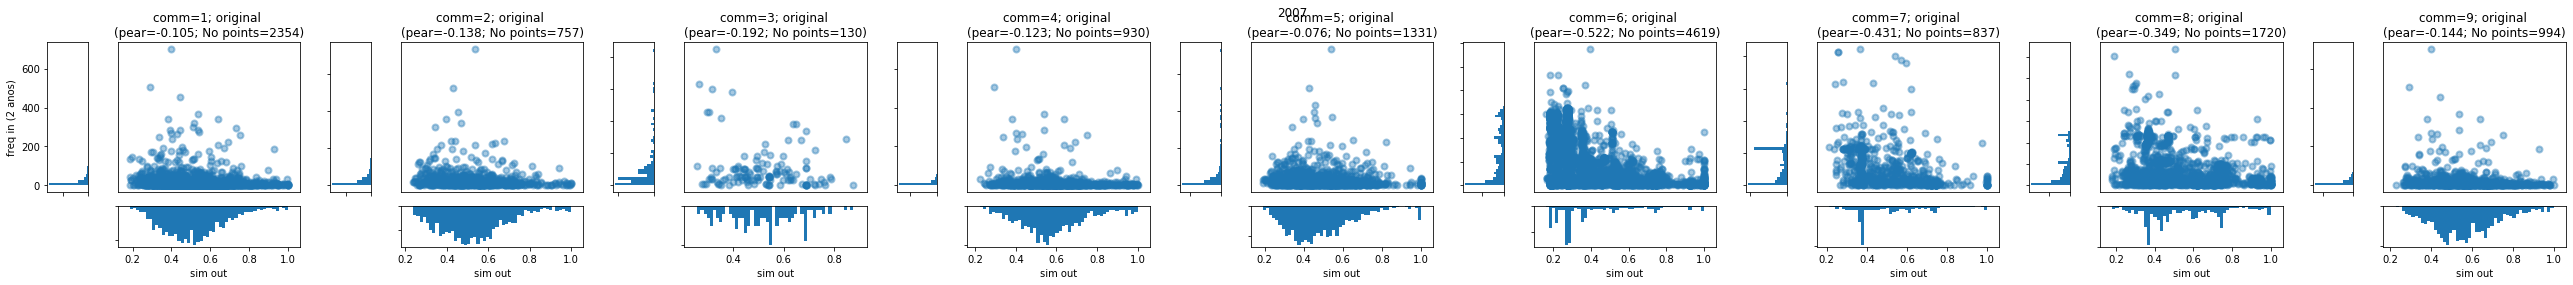

In [23]:
div_points = get_div_points(top_min25,authors_out_sim,freq_in,valid_authors_by_area)
plot_div_points(div_points,'sim out','freq in (2 anos)','min 25 citações e referências',header)

In [22]:
# div_points = get_div_points(top1000_in,authors_in_div,freq_in)
# plot_div_points(div_points,'div in','freq in','top 1000')

In [23]:
# div_points = get_div_points(top1000_in,authors_in_div,freq_out)
# plot_div_points(div_points,'div in','freq out','top 1000')

In [24]:
# div_points = get_div_points(top1000_in,authors_out_div,freq_out)
# plot_div_points(div_points,'div out','freq out','top 1000')

In [31]:
def get_assortativity(filenames,year,authors_in_div):
    print(list(authors_in_div.keys())[:10])
    assorts = []
    for filename in filenames:
        ranking = top_min25[str(year)]
        net = xnet.xnet2igraph(filename)

        valid_vtxs = []
        divs = []
        for author in net.vs:
            try:
                d = authors_in_div[str(author['name'])][str(year)]
                divs.append(d)
                valid_vtxs.append(author['name'])
            except:
                pass
    
        net = net.subgraph(valid_vtxs)
        net.vs['div'] = divs
        assort = net.assortativity('div')
        assorts.append(assort)
        
        year += 1
        del net
    return assorts

In [32]:
year = 1990
filenames = sorted(glob.glob('data/colabs/wcomb/colab*_multi1.xnet'))
filenames

['data/colabs/wcomb/colab_1986_1990_0.8_selected_wc_multi1.xnet',
 'data/colabs/wcomb/colab_1987_1991_0.8_selected_wc_multi1.xnet',
 'data/colabs/wcomb/colab_1988_1992_0.8_selected_wc_multi1.xnet',
 'data/colabs/wcomb/colab_1989_1993_0.8_selected_wc_multi1.xnet',
 'data/colabs/wcomb/colab_1990_1994_0.8_selected_wc_multi1.xnet',
 'data/colabs/wcomb/colab_1991_1995_0.8_selected_wc_multi1.xnet',
 'data/colabs/wcomb/colab_1992_1996_0.8_selected_wc_multi1.xnet',
 'data/colabs/wcomb/colab_1993_1997_0.8_selected_wc_multi1.xnet',
 'data/colabs/wcomb/colab_1994_1998_0.8_selected_wc_multi1.xnet',
 'data/colabs/wcomb/colab_1995_1999_0.8_selected_wc_multi1.xnet',
 'data/colabs/wcomb/colab_1996_2000_0.8_selected_wc_multi1.xnet',
 'data/colabs/wcomb/colab_1997_2001_0.8_selected_wc_multi1.xnet',
 'data/colabs/wcomb/colab_1998_2002_0.8_selected_wc_multi1.xnet',
 'data/colabs/wcomb/colab_1999_2003_0.8_selected_wc_multi1.xnet',
 'data/colabs/wcomb/colab_2000_2004_0.8_selected_wc_multi1.xnet',
 'data/col

In [33]:
assort_in = get_assortativity(filenames,year,authors_in_div)
assort_out = get_assortativity(filenames,year,authors_out_div)

['2156212925', '2028685499', '2682499677', '2720942211', '2146735552', '2115742620', '2422938866', '2133009506', '2107138249', '2015048377']
['2146735552', '2115742620', '2422938866', '2133009506', '2154186918', '2625574330', '2152124338', '2335724165', '2402693797', '980010']


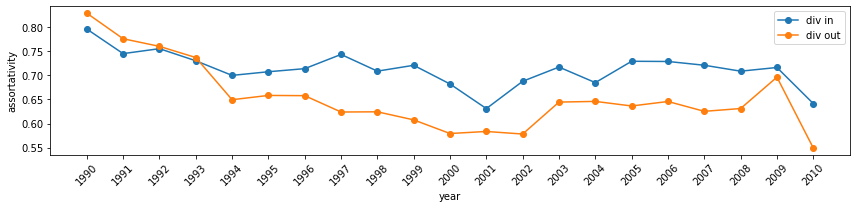

In [34]:
plt.figure(figsize=(12,3))
years = [1990+i for i in range(21)]
plt.plot(years,assort_in,'o',ls='-',label='div in')
plt.plot(years,assort_out,'o',ls='-',label='div out')
plt.legend()
plt.xlabel('year')
plt.ylabel('assortativity')
plt.xticks(years,rotation=45)
plt.tight_layout()
plt.savefig('assortativity.pdf',)

In [ ]:
# 2lvl 2multilevel ok
# min de 25 citaçoes e referencias ok
# numero de citacoes no futuro (2 anos) ok
# pintar por area dominante, fazer por grande area ok
# rede de colaboraço comuniades vs divs in ou div out (histograma dos autores)
# assortatividade divs com os autores que tem informaçoes ok

In [86]:
def get_hist_div_comm(filenames,year,authors_in_div,top500_in):
    for filename in filenames:
        print(year)
        ranking = top_min25[str(year)]
        net = xnet.xnet2igraph(filename)

        valid_authors = set(top500_in[str(year)])
        div_by_comm = defaultdict(lambda:[])
        for author in net.vs:
            try:
#                 print(author['name'])
                a = str(author['name'])
                if not a in valid_authors:
                    continue
                d = authors_in_div[a][str(year)]
                div_by_comm[author['community']].append(d)
            except:
                pass
        
        c = 0
        for comm,values in div_by_comm.items():
            
            if len(values) >= 50 and comm != '-1':
                plt.hist(values,bins=50,range=(1,3))
                plt.savefig('temp/div_comm/%d_%s.pdf' % (year,comm))
                plt.clf()
                c += 1
        print(c)
        
        year += 1
        del net

In [87]:
get_hist_div_comm(filenames,year,authors_in_div,top500_in)

1990
2
1991
1
1992
1
1993
1
1994
1
1995
1
1996
2
1997
2
1998
1
1999
1
2000
2
2001
2
2002
3
2003
2
2004
4
2005
4
2006
4
2007
2
2008
2
2009
2
2010
2


<Figure size 432x288 with 0 Axes>

In [32]:
data.vs['times_cited'][0]

4354.0

In [ ]:
history_in